In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

import torch

In [99]:
DATA_ROOT = 'data/Cityscapes/'
NUM_CLASSES = 19   

BATCH_SIZE = 16                     
LR = 0.05    # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 5   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 5

(1024, 2048, 1)
(1024, 2048, 3)


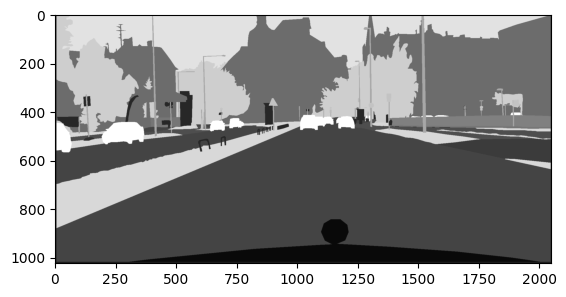

In [32]:
mask = plt.imread(DATA_ROOT + 'labels/aachen_000001_000019_gtFine_labelIds.png')
mask = np.expand_dims(mask, axis=2)
print(mask.shape)
plt.imshow(mask[..., 0], cmap='gray');

img = plt.imread(DATA_ROOT + 'images/aachen_000001_000019_leftImg8bit.png')
print(img.shape)
#plt.imshow(img[..., 0], cmap='gray');


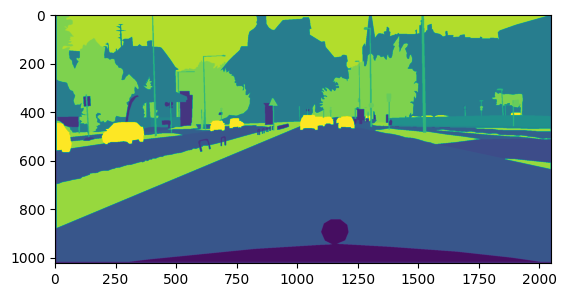

In [42]:
mask = plt.imread(DATA_ROOT + 'labels/aachen_000001_000019_gtFine_labelIds.png')*255
mask = np.expand_dims(mask, axis=2)
plt.imshow(mask[..., 0]);



In [34]:
np.unique(mask * 255)


array([ 0.,  1.,  3.,  4.,  5.,  6.,  7.,  8., 11., 12., 13., 17., 19.,
       20., 21., 22., 23., 26.], dtype=float32)

In [40]:
labels =[
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "light",
    "sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motocycle",
    "bicycle"]

print(len(labels))

19


[  0 255]


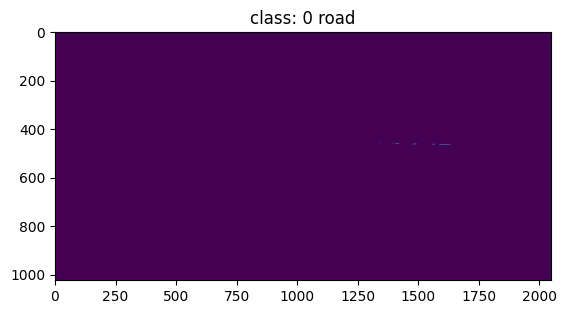

[  0 255]


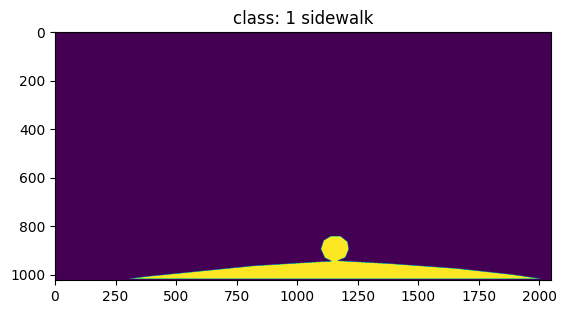

[0]


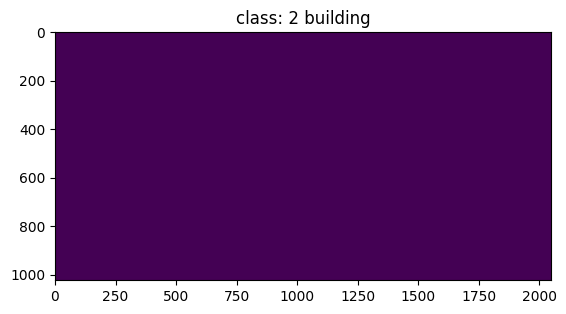

[  0 255]


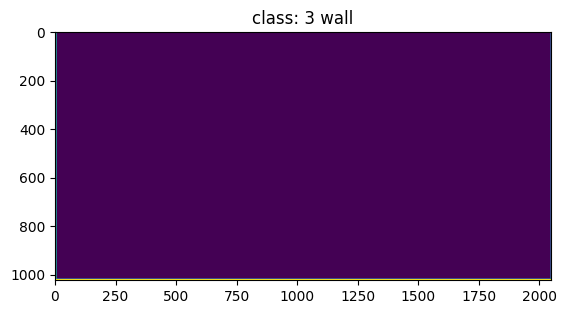

[  0 255]


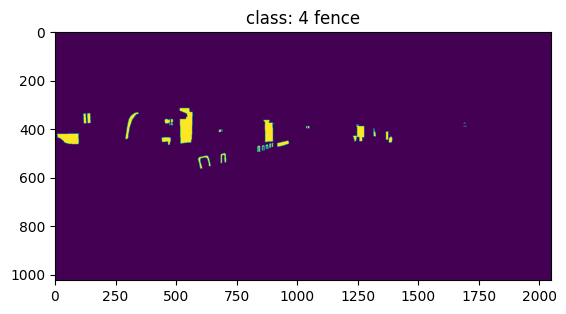

[  0 255]


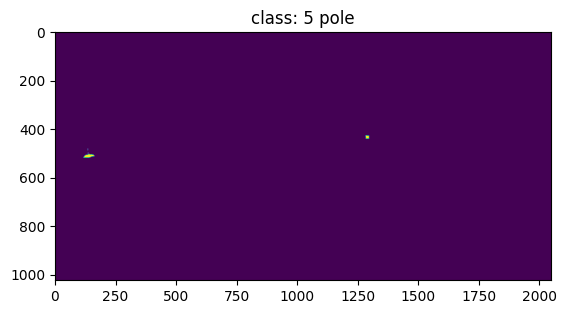

[  0 255]


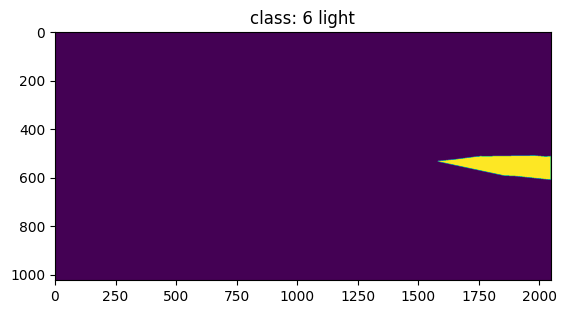

[  0 255]


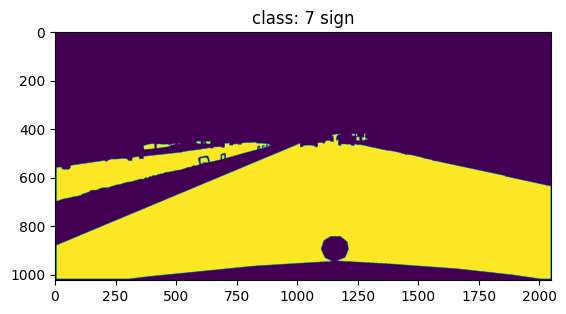

[  0 255]


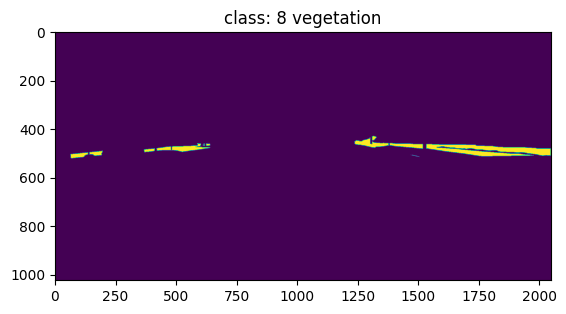

[0]


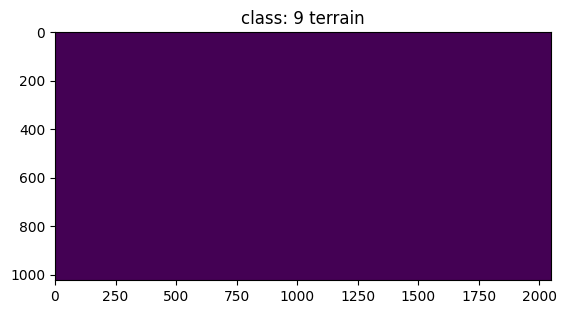

[0]


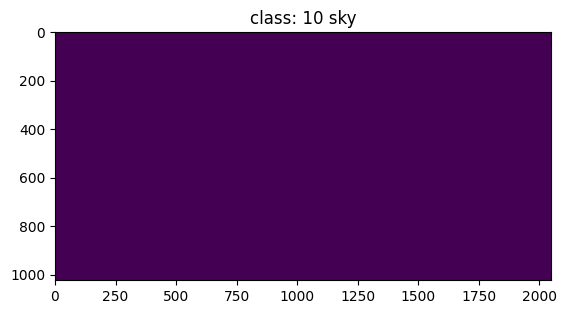

[  0 255]


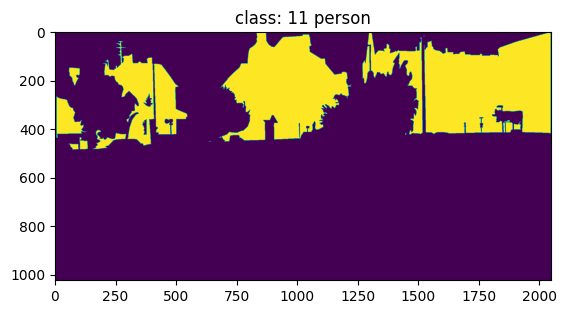

[  0 255]


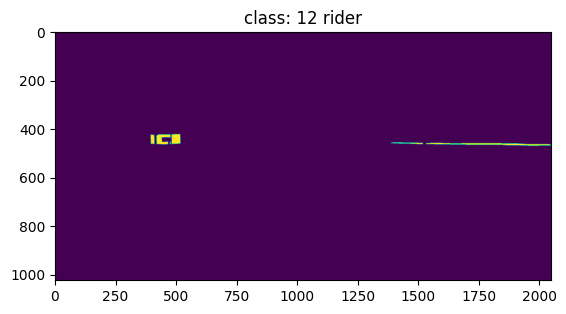

[  0 255]


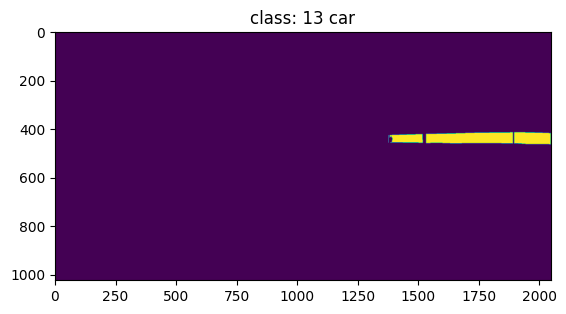

[0]


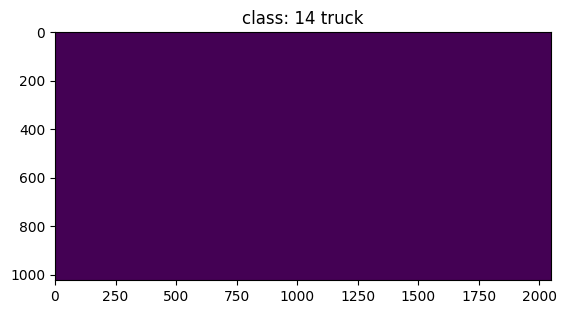

[0]


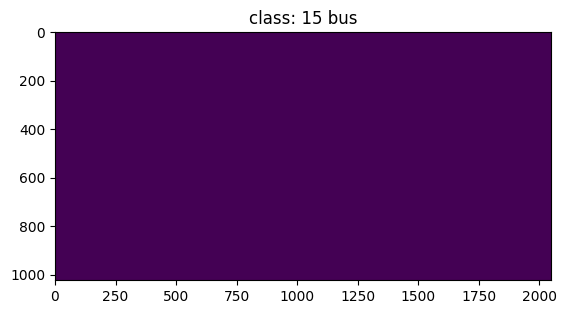

[0]


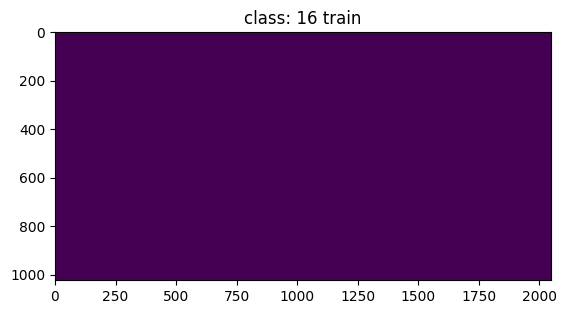

[  0 255]


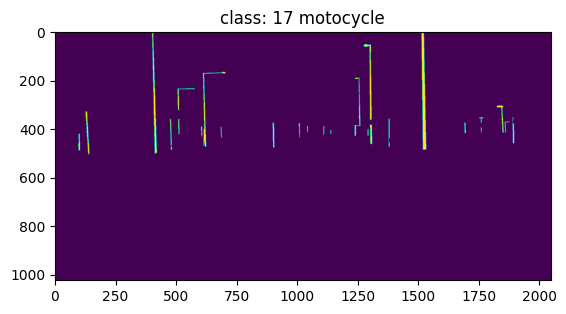

[0]


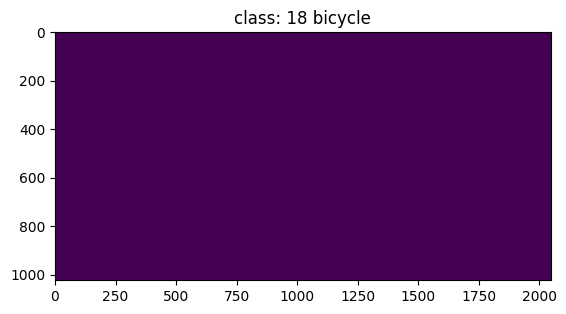

In [44]:
for i in range(19):
    mask = plt.imread(DATA_ROOT + 'labels/aachen_000001_000019_gtFine_labelIds.png')*255
    mask = np.expand_dims(mask, axis=2)
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

In [60]:
images = []
labels = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if 'images' in f:
            images.append(f)
        elif 'labels' in f:
            labels.append(f)
        else:
            break

In [61]:
print(len(images))
print(len(labels))

750
750


In [62]:
df = pd.DataFrame({'images': images, 'labels': labels})
df.sort_values(by='images',inplace=True)

df.reset_index(drop=True, inplace=True)
df.head(5)

,images,labels
0,data/Cityscapes/images/aachen_000001_000019_le...,data/Cityscapes/labels/tubingen_000039_000019_...
1,data/Cityscapes/images/aachen_000002_000019_le...,data/Cityscapes/labels/dusseldorf_000146_00001...
2,data/Cityscapes/images/aachen_000004_000019_le...,data/Cityscapes/labels/hamburg_000000_090742_g...
3,data/Cityscapes/images/aachen_000009_000019_le...,data/Cityscapes/labels/frankfurt_000001_073464...
4,data/Cityscapes/images/aachen_000012_000019_le...,data/Cityscapes/labels/tubingen_000054_000019_...


In [64]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

In [68]:
class ssDrive(Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        
        self.image_arr = self.data.iloc[:,0]
        self.label_arr = self.data.iloc[:,1]
        
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):

        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
#         mask = Image.open(self.label_arr[index])
#         mask = mask.resize((256, 256))
#         mask = np.asarray(mask)
        
        for i in range(19):
            cls_mask = np.where(mask == i, 255, 0)
            cls_mask = cls_mask.astype('float')
            cls_mask = cv2.resize(cls_mask, (256, 256))

            masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

torch.Size([3, 256, 256]) torch.Size([19, 256, 256])


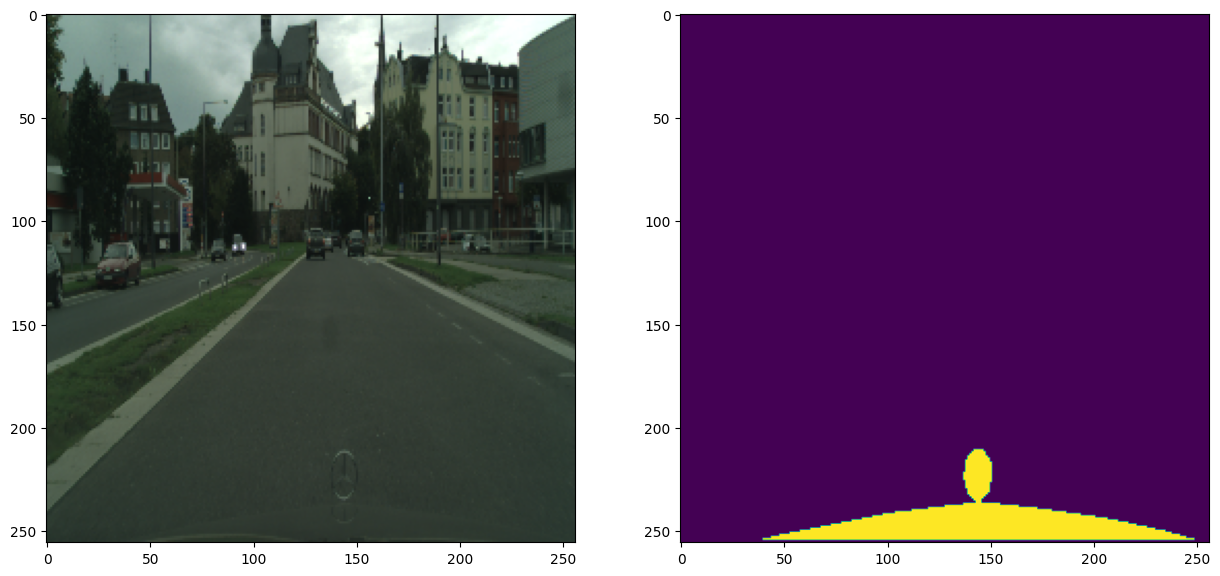

In [82]:
dataset = ssDrive(df)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 1])
plt.show()

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.3)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_data = ssDrive(X_train)
test_data = ssDrive(X_test)

In [85]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 19, 256, 256])
tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


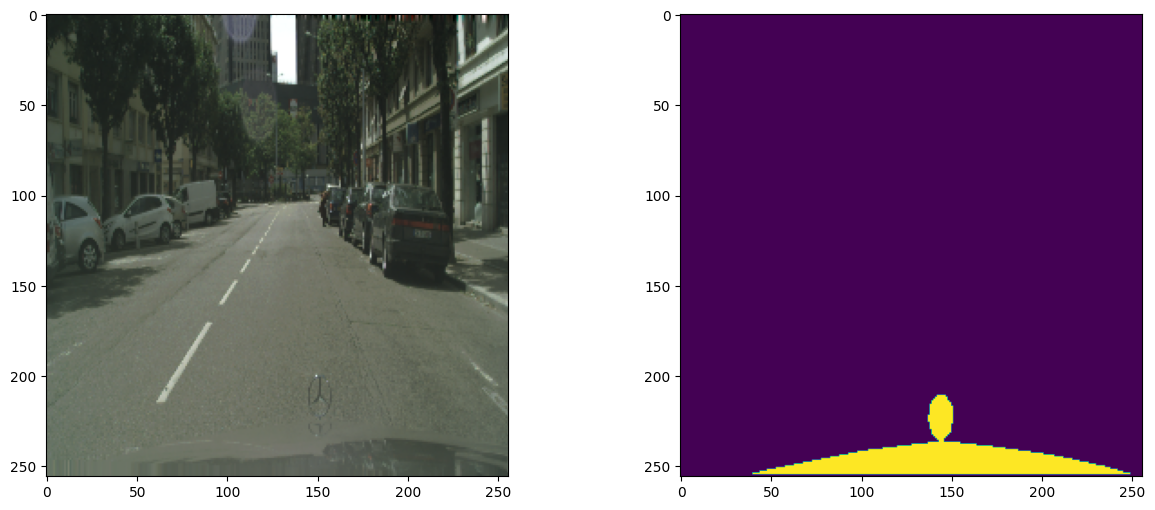

In [87]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 1])
    break

In [88]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as modelzoo

backbone_url = 'https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth'


class ConvBNReLU(nn.Module):

    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1,
                 dilation=1, groups=1, bias=False):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(
            in_chan, out_chan, kernel_size=ks, stride=stride,
            padding=padding, dilation=dilation,
            groups=groups, bias=bias)

        self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv(x)
        feat = self.bn(feat)
        feat = self.relu(feat)
        return feat


class UpSample(nn.Module):

    def __init__(self, n_chan, factor=2):
        super(UpSample, self).__init__()
        out_chan = n_chan * factor * factor
        self.proj = nn.Conv2d(n_chan, out_chan, 1, 1, 0)
        self.up = nn.PixelShuffle(factor)
        self.init_weight()

    def forward(self, x):
        feat = self.proj(x)
        feat = self.up(feat)
        return feat

    def init_weight(self):
        nn.init.xavier_normal_(self.proj.weight, gain=1.)


class DetailBranch(nn.Module):

    def __init__(self):
        super(DetailBranch, self).__init__()
        self.S1 = nn.Sequential(
            ConvBNReLU(3, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S2 = nn.Sequential(
            ConvBNReLU(64, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S3 = nn.Sequential(
            ConvBNReLU(64, 128, 3, stride=2),
            ConvBNReLU(128, 128, 3, stride=1),
            ConvBNReLU(128, 128, 3, stride=1),
        )

    def forward(self, x):
        feat = self.S1(x)
        feat = self.S2(feat)
        feat = self.S3(feat)
        return feat


class StemBlock(nn.Module):

    def __init__(self):
        super(StemBlock, self).__init__()
        self.conv = ConvBNReLU(3, 16, 3, stride=2)
        self.left = nn.Sequential(
            ConvBNReLU(16, 8, 1, stride=1, padding=0),
            ConvBNReLU(8, 16, 3, stride=2),
        )
        self.right = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.fuse = ConvBNReLU(32, 16, 3, stride=1)

    def forward(self, x):
        feat = self.conv(x)
        feat_left = self.left(feat)
        feat_right = self.right(feat)
        feat = torch.cat([feat_left, feat_right], dim=1)
        feat = self.fuse(feat)
        return feat


class CEBlock(nn.Module):

    def __init__(self):
        super(CEBlock, self).__init__()
        self.bn = nn.BatchNorm2d(128)
        self.conv_gap = ConvBNReLU(128, 128, 1, stride=1, padding=0)
        self.conv_last = ConvBNReLU(128, 128, 3, stride=1)

    def forward(self, x):
        feat = torch.mean(x, dim=(2, 3), keepdim=True)
        feat = self.bn(feat)
        feat = self.conv_gap(feat)
        feat = feat + x
        feat = self.conv_last(feat)
        return feat


class GELayerS1(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS1, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv(feat)
        feat = self.conv2(feat)
        feat = feat + x
        feat = self.relu(feat)
        return feat


class GELayerS2(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS2, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv1 = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=2,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
        )
        self.dwconv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=mid_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.shortcut = nn.Sequential(
            nn.Conv2d(
                in_chan, in_chan, kernel_size=3, stride=2,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(
                in_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv1(feat)
        feat = self.dwconv2(feat)
        feat = self.conv2(feat)
        shortcut = self.shortcut(x)
        feat = feat + shortcut
        feat = self.relu(feat)
        return feat


class SegmentBranch(nn.Module):

    def __init__(self):
        super(SegmentBranch, self).__init__()
        self.S1S2 = StemBlock()
        self.S3 = nn.Sequential(
            GELayerS2(16, 32),
            GELayerS1(32, 32),
        )
        self.S4 = nn.Sequential(
            GELayerS2(32, 64),
            GELayerS1(64, 64),
        )
        self.S5_4 = nn.Sequential(
            GELayerS2(64, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
        )
        self.S5_5 = CEBlock()

    def forward(self, x):
        feat2 = self.S1S2(x)
        feat3 = self.S3(feat2)
        feat4 = self.S4(feat3)
        feat5_4 = self.S5_4(feat4)
        feat5_5 = self.S5_5(feat5_4)
        return feat2, feat3, feat4, feat5_4, feat5_5


class BGALayer(nn.Module):

    def __init__(self):
        super(BGALayer, self).__init__()
        self.left1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        self.left2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=2,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        )
        self.right1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.right2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        self.up1 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.up2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        self.conv = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_d, x_s):
        left1 = self.left1(x_d)
        left2 = self.left2(x_d)
        right1 = self.right1(x_s)
        right2 = self.right2(x_s)
        right1 = self.up1(right1)
        left = left1 * torch.sigmoid(right1)
        right = left2 * torch.sigmoid(right2)
        right = self.up2(right)
        out = self.conv(left + right)
        return out


class SegmentHead(nn.Module):

    def __init__(self, in_chan, mid_chan, n_classes, up_factor=8, aux=False):
        super(SegmentHead, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, 3, stride=1)
        self.drop = nn.Dropout(0.1)

        out_channels = n_classes * (up_factor ** 2)
        self.conv_out = nn.Sequential(
            nn.Conv2d(mid_chan, out_channels, kernel_size=1, stride=1, padding=0),
            nn.PixelShuffle(up_factor)
        )

    def forward(self, x):
        feat = self.conv(x)
        feat = self.drop(feat)
        feat = self.conv_out(feat)
        return feat


class BiSeNetV2(nn.Module):

    def __init__(self, n_classes, output_aux=True, pretrained=False):
        super(BiSeNetV2, self).__init__()
        self.output_aux = output_aux
        self.pretrained = pretrained
        self.detail = DetailBranch()
        self.segment = SegmentBranch()
        self.bga = BGALayer()

        self.head = SegmentHead(128, 1024, n_classes, up_factor=8, aux=False)
        if self.output_aux:
            self.aux2 = SegmentHead(16, 128, n_classes, up_factor=4)
            self.aux3 = SegmentHead(32, 128, n_classes, up_factor=8)
            self.aux4 = SegmentHead(64, 128, n_classes, up_factor=16)
            self.aux5_4 = SegmentHead(128, 128, n_classes, up_factor=32)
        self.test_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.init_weights()

    def forward(self, x, test=False, use_test_resize=None):
        size = x.size()[2:]
        feat_d = self.detail(x)
        feat2, feat3, feat4, feat5_4, feat_s = self.segment(x)
        feat_head = self.bga(feat_d, feat_s)

        logits = self.head(feat_head)
        if self.output_aux and not test:
            logits_aux2 = self.aux2(feat2)
            logits_aux3 = self.aux3(feat3)
            logits_aux4 = self.aux4(feat4)
            logits_aux5_4 = self.aux5_4(feat5_4)
            return logits, logits_aux2, logits_aux3, logits_aux4, logits_aux5_4
        if test and use_test_resize:
            return self.test_up(logits)

        return logits

    def init_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_out')
                if not module.bias is None: nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                if hasattr(module, 'last_bn') and module.last_bn:
                    nn.init.zeros_(module.weight)
                else:
                    nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
        if self.pretrained:
            self.load_pretrain()

    def load_pretrain(self):
        state = modelzoo.load_url(backbone_url)
        for name, child in self.named_children():
            if name in state.keys():
                child.load_state_dict(state[name], strict=True)

    def get_params(self):
        def add_param_to_list(mod, wd_params, nowd_params):
            for param in mod.parameters():
                if param.dim() == 1:
                    nowd_params.append(param)
                elif param.dim() == 4:
                    wd_params.append(param)
                else:
                    print(name)

        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            if 'head' in name or 'aux' in name:
                add_param_to_list(child, lr_mul_wd_params, lr_mul_nowd_params)
            else:
                add_param_to_list(child, wd_params, nowd_params)
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params

In [89]:
learning_rate = 0.001
epochs = 1

In [127]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [91]:
from torchinfo import summary

net = BiSeNetV2(n_classes=19).to(device)

In [92]:
sample = (next(iter(train_data_loader)))
sample[1].shape

torch.Size([8, 19, 256, 256])

In [108]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

In [123]:
import torch.optim as optim
# Define loss function

#criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
criterion = DiceLoss()

parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [134]:
import time


epoch_losses = []
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = data.to(DEVICE), labels.to(DEVICE)      
        data = np.copy(data.numpy())
        labels = np.copy(labels.numpy())



        
        optimizer.zero_grad()
        outputs = net(data)   
        
        
        #loss = nn.CrossEntropyLoss(outputs,labels)# - torch.log(DiceLoss(outputs, labels))
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx % 200 == 0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    end_time = time.time()
    print(f'Spend time for 1 epoch: {end_time - start_time} sec')
    
    epoch_losses.append(epoch_loss)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.